## Import libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import numpy as np
from numpy import polyfit
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from keras.callbacks import ModelCheckpoint, EarlyStopping

# *****************************************************
## Import And Preprocess Data Set

In [4]:
df = pd.read_csv("/content/drive/My Drive/climate5April/CO2/FinalCo2.csv")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
# Convert Effective date type to datetime
df["Date"] = pd.to_datetime(df["Date"])
# df['DATE'] = pd.to_datetime(df['DATE']).dt.tz_localize(None)
df.head(2)

,Date,Value
0,1959-03-01,316.65
1,1959-04-01,317.72


In [ ]:
df.tail()

,Date,Value
287,2023-12-01,421.86
288,2024-01-01,422.80
289,2024-02-01,424.62
290,2024-03-01,425.38
291,2024-04-01,426.57


In [5]:
df=df.loc[df['Date']>='2000-01-01']

In [6]:
df.set_index('Date', inplace=True)

df.head()

,Value
Date,
2000-01-01,369.45
2000-02-01,369.71
2000-03-01,370.75
2000-04-01,371.98
2000-05-01,371.74


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 782 entries, 1959-03-01 to 2024-04-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   782 non-null    float64
dtypes: float64(1)
memory usage: 12.2 KB


In [7]:
train = df[:190]
valid = df[190:250]
test = df[250:]

scaler = MinMaxScaler()

# Fit scaler on training data and transform all subsets
train_data = scaler.fit_transform(train[['Value']])
validate_data = scaler.transform(valid[['Value']])
test_data = scaler.transform(test[['Value']])

print("Train data size:", len(train_data))
print("Validation data size:", len(validate_data))
print("Test data size:", len(test_data))


Train data size: 190
Validation data size: 60
Test data size: 42


In [15]:
from keras.layers import Bidirectional
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 1 # Number of time steps to look back
X_train, y_train = create_sequences(train_data, seq_length)
X_val,y_val=create_sequences(validate_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [16]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [17]:
model = Sequential()
model.add(Bidirectional(LSTM(200, return_sequences=True), input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(200)))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))


model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=80, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=1, callbacks=[early_stopping])


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 246ms/step - loss: 0.2725 - val_loss: 0.7080
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0905 - val_loss: 0.0315
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.0342 - val_loss: 0.0039
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0236 - val_loss: 0.1383
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0232 - val_loss: 0.1060
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0146 - val_loss: 0.0121
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0089 - val_loss: 0.0053
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0050 - val_loss: 0.0178
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0037 - val_loss: 0.0045
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0017 - val_

In [18]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_val)
test_predict1 = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [19]:
# Inverse transform the predictions and actual values
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_val = scaler.inverse_transform(y_val.reshape(-1, 1))
test_predict1 = scaler.inverse_transform(test_predict1)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

# MSE
train_mse = mean_squared_error(y_train, train_predict)
test_mse = mean_squared_error(y_test, test_predict1)

# RMSE
train_rmse = sqrt(train_mse)
test_rmse = sqrt(test_mse)

# MAE
train_mae = mean_absolute_error(y_train, train_predict)
test_mae = mean_absolute_error(y_test, test_predict1)

# R^2
train_r2 = r2_score(y_train, train_predict)
test_r2 = r2_score(y_test, test_predict1)

# Output
print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Train MAE: {train_mae}')
print(f'Test MAE: {test_mae}')
print(f'Train R²: {train_r2}')
print(f'Test R²: {test_r2}')


Train MSE: 1.640416852896677
Test MSE: 1.6898924119583059
Train RMSE: 1.2807875908583268
Test RMSE: 1.2999586193253636
Train MAE: 1.0634277343749996
Test MAE: 1.1317497141768307
Train R²: 0.9823147304421062
Test R²: 0.8343234037048686


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


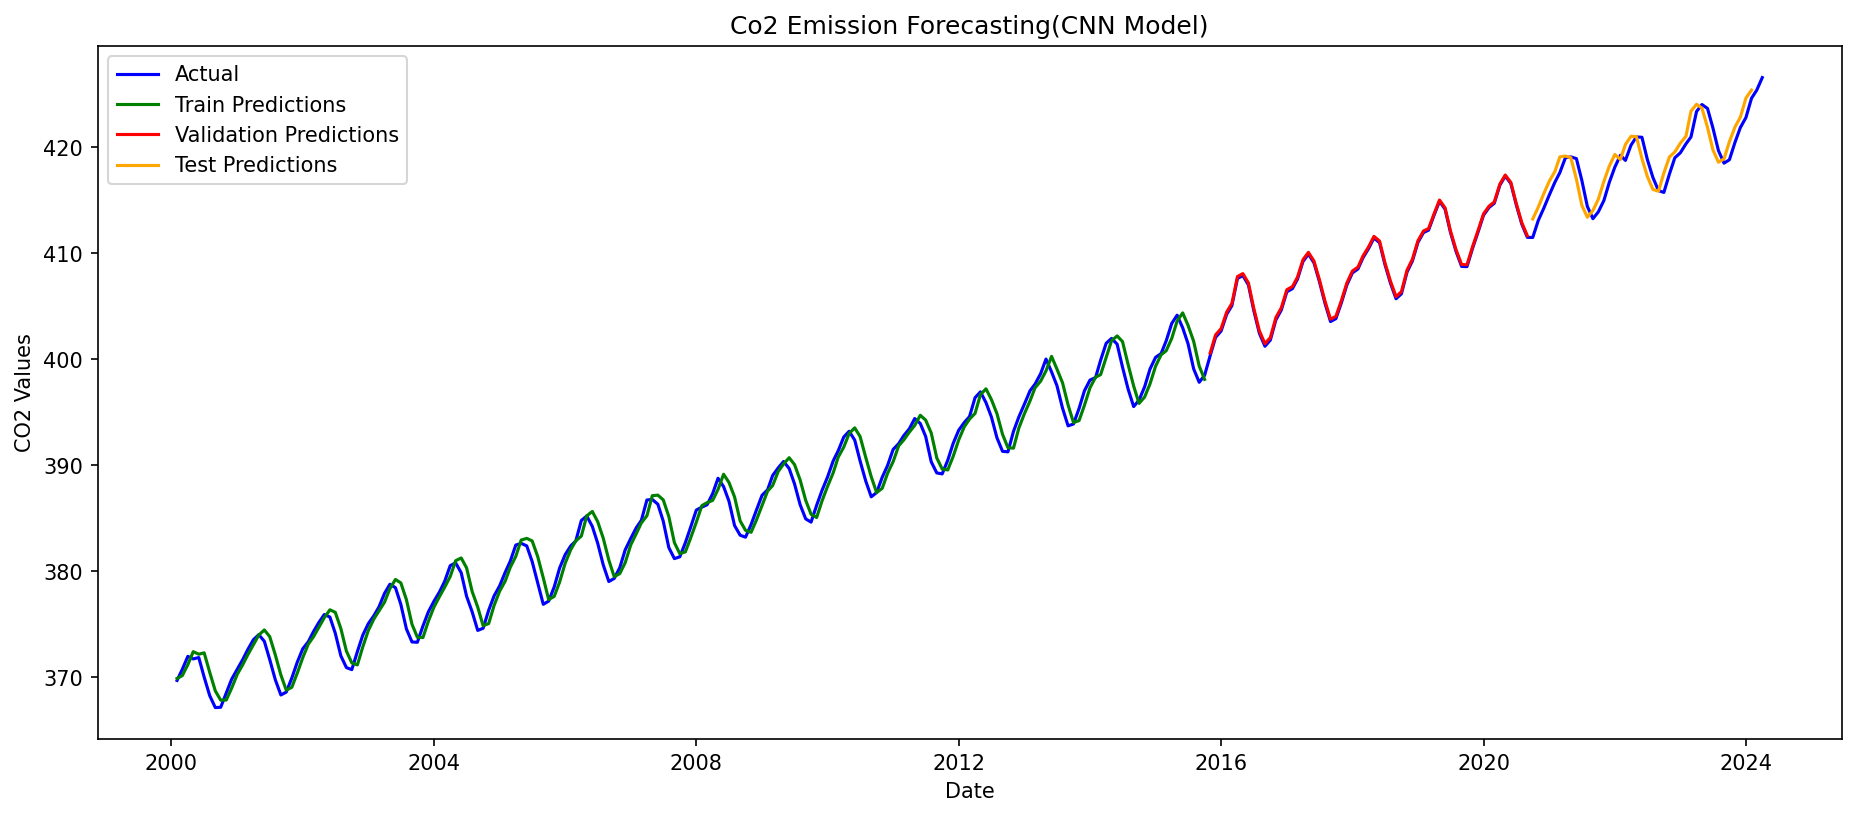

In [21]:
# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
val_predictions = model.predict(X_val)

train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
val_predictions = scaler.inverse_transform(val_predictions)


plt.figure(figsize=(15, 6),dpi=150)

plt.plot(df.index[seq_length:], df['Value'][seq_length:], label='Actual', color='blue')

plt.plot(df.index[seq_length:seq_length+len(train_predictions)], train_predictions, label='Train Predictions',color='green')


val_pred_index = range(seq_length+len(train_predictions), seq_length+len(train_predictions)+len(val_predictions))
plt.plot(df.index[val_pred_index], val_predictions, label='Validation Predictions', color='red')

test_pred_index = range(seq_length+len(train_predictions)+len(val_predictions), seq_length+len(train_predictions)+len(val_predictions)+len(test_predictions))
plt.plot(df.index[test_pred_index], test_predictions, label='Test Predictions', color='orange')

plt.title('Co2 Emission Forecasting(CNN Model)')
plt.xlabel('Date')
plt.ylabel('CO2 Values')
plt.legend(loc='upper left')
plt.show()